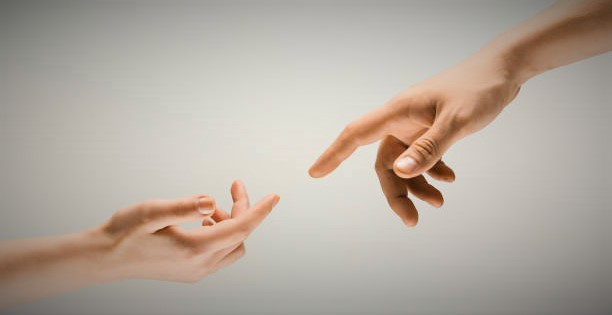

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import glob
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [25]:
Alone=0
Spontan=1
Sync=2

def LoadData(path):
        AloneList=[];SpontanList=[];SyncList=[]
        all_files = glob.glob(path + "/*")
        for folder in all_files:
            print("\nloading in" ,os.path.basename(folder), ':')
            files = glob.glob(folder + "/*.csv")
            files=last3(files)
            for filename in files:
                df = pd.read_csv(filename, index_col=None, header=0)
                type = None
                
                if("Alone" in filename):
                    type = Alone
                    df=transform(df,type)
#                     df["State"] = type
                    AloneList.append(df)
                elif("Sync" in filename):
                    type = Sync
                    df=transform(df,type)
#                     df["State"] = type
                    SyncList.append(df)
                elif("Spontan" in filename):
                    type = Spontan
                    df=transform(df,type)
#                     df["State"] = type
                    SpontanList.append(df)
                   
                print(os.path.basename(filename), type)
        listData = np.array([AloneList,SpontanList,SyncList])
        return listData


def last3(files):
    lafile=[]
    for i in range(3):
        latest_file = max(files, key=os.path.getmtime)
        lafile.append(latest_file)
        files.remove(latest_file)
    return lafile

def transform(df,type):
    df=df.dropna().reset_index(drop=True)
    df.iloc[:,0] = df.iloc[:,0] - df.iloc[:,0][0]
    df = remove7(df)
    df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]
#     df.iloc[:,0]=df.iloc[:,0].round()
    df.iloc[:,0] = df.iloc[:,0].astype(int)
    if type==0:
        return df
    df = df[df.iloc[:,3] != 1]
    df = df.drop(columns=df.columns[3])
    df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
    df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
    df_right = df_right.drop(columns=df_right.columns[2])
    df_left = df_left.drop(columns=df_left.columns[2])
    df=pd.merge(df_right, df_left, left_index=True, right_index=True)
    df.columns=[c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
    return df

    
def remove7(df):
    return df[df.iloc[:,0]>7].reset_index(drop=True)

# def toVector(df):
#     j=0;arr=[]
#     for i in range(5):
#         df1=df.iloc[j::5, :]
#         arr.append(df1)
#         j+=1
#     df2=pd.concat(arr,join='inner')
#     return arr


In [26]:
pathTrain=r'C:\Users\נעמיה\data-science\extraFiles\Training'
pathTest=r'C:\Users\נעמיה\data-science\extraFiles\Validation'
print('Load the train data:')
listTrain=LoadData(pathTrain)
print('\nLoad the test data:')
listTest=LoadData(pathTest)

Load the train data:

loading in Evyatar Cohen :
Evyatar636771054555711409Alone.csv 0
Evyatar636771053639929594Sync.csv 2
Evyatar636771052727603804Spontan.csv 1

loading in Nofar Social_Nuero :
Nofar636759797397919664Sync.csv 2
Nofar636759796290435160Alone.csv 0
Nofar636759795182793299Spontan.csv 1

loading in Oriya Social_Nuero :
Oriya636759806131350399Sync.csv 2
Oriya636759805268396661Alone.csv 0
Oriya636759804404113837Spontan.csv 1

loading in Orya Kalmanovitz :
OryaB636771084494502229Sync.csv 2
OryaB636771083605535985Spontan.csv 1
OryaB636771082736601528Alone.csv 0

loading in Revital Marbel :
Revital636770957894370062Sync.csv 2
Revital636770957038873193Spontan.csv 1
Revital636770955999435879Alone.csv 0

loading in Shahar Terner :
Sachar636771047408504303Alone.csv 0
Sachar636771046527112972Sync.csv 2
Sachar636771045591258071Spontan.csv 1

loading in Shelly Social_Nuero :
Shelly636759789526313406Sync.csv 2
Shelly636759788383205274Alone.csv 0
Shelly636759787508979097Spontan.csv 1

lo

In [27]:
print(listTrain.shape)
print(listTest.shape)

(3, 9)
(3, 3)


In [28]:
listTrain[2][0]

,TimeRight,FrameIDRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,PitchRight,RollRight,...,YawLeft,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft
0,7,139878,121.9688,230.3867,61.91891,7.825050,-222.591000,121.91490,0.959785,-1.426111,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.0,0.0
1,7,139880,121.6194,226.1235,64.10963,-32.326430,-248.082700,109.73410,0.956199,-1.415896,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.0,0.0
2,7,139882,121.0388,222.2049,65.98412,-28.869160,-210.964200,109.70620,0.951746,-1.412059,...,0.683048,-106.3970,217.4241,50.26434,-262.3120,24.76191,42.24427,0.0,0.0,0.0
3,7,139884,120.6072,219.1105,67.75517,-18.538570,-156.224000,112.23140,0.944151,-1.411600,...,0.709288,-105.9420,213.8663,52.21570,-271.2896,29.79138,35.81071,0.0,0.0,0.0
4,7,139885,120.4184,217.8251,68.88145,-22.010350,-149.861400,131.31480,0.932912,-1.409807,...,0.731741,-105.8699,212.5583,53.02802,-275.5691,32.85570,32.98580,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,74,147698,111.3970,182.9246,34.27466,-42.475920,-117.845800,-61.32522,0.395246,-1.971680,...,1.065970,-127.3144,194.4717,59.52803,-299.5664,15.22464,16.52840,0.0,0.0,0.0
4099,74,147700,110.0870,180.8389,32.92039,-71.148420,-111.439600,-69.28531,0.365014,-1.987410,...,1.007618,-126.9333,193.0801,58.90355,-298.9101,12.87815,18.89758,0.0,0.0,0.0
4100,74,147702,109.1714,179.3461,31.84416,-46.123690,-69.914710,-57.69822,0.355285,-1.995915,...,0.956325,-126.9241,191.1363,58.91284,-302.6545,12.99574,26.75648,0.0,0.0,0.0
4101,74,147704,108.9017,178.8129,31.02029,-15.531000,-5.445981,-50.80544,0.355584,-2.007045,...,0.901075,-126.4018,188.6597,59.13661,-308.9988,15.97083,37.08796,0.0,0.0,0.0


In [29]:
AloneRight = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\HandRight.csv')
AloneRight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [30]:
#drop rows with NaN value
AloneRight = AloneRight.dropna()

#change columns name
AloneRight = transform(AloneRight,0)

#replace 'left' at 'right'
for index, row in AloneRight.iterrows():
    AloneRight.loc[index,'HandType']='right'
    
#if there are duplicate rows - delete them
AloneRight=AloneRight.drop_duplicates()

In [31]:
dff=listTest[0][0]
dff.iloc[[5]].reset_index(drop=True)

,Time,FrameID,HandType,hands,PositionX,PositionY,PositionZ,VelocityX,VelocityY,VelocityZ,...,Yaw,WristPosX,WristPosY,WristPosZ,ElbowposX,ElbowPosY,ElbowPosZ,GrabStrenth,GrabAngle,PinchStrength
0,7,112185,left,1,-125.5271,258.4183,53.24498,166.5777,-254.0148,-28.93197,...,1.344015,-188.5147,235.6829,60.26236,-370.7249,86.82882,107.6254,0.074778,1.100305,0.0


In [32]:
def mergeAlone(listdata):
    for i in range(len(listdata)):
        temp=AloneRight
        if len(listdata[i])>len(AloneRight):
            temp=pd.concat([AloneRight,AloneRight]).reset_index(drop=True)
        spare = len(temp)-len(listdata[i])
        temp.drop(temp.tail(spare).index,inplace=True)
        temp = temp.drop(columns=temp.columns[[2,3]])
        listdata[i] = listdata[i].drop(columns=listdata[i].columns[[2,3]])
        df=pd.merge(temp, listdata[i], left_index=True, right_index=True)
        df.columns = [c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
        listdata[i] = df
    return listdata

In [33]:
listTrain[Alone]=mergeAlone(listTrain[Alone])
listTest[Alone]=mergeAlone(listTest[Alone])

In [34]:
listTrain[Alone][0]

,TimeRight,FrameIDRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,PitchRight,RollRight,...,YawLeft,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft
0,7,16287,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,-0.092033,0.108262,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,7,16289,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,-0.111674,0.126925,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0
2,7,16291,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,-0.140004,0.127219,...,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0
3,7,16293,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,-0.166623,0.122782,...,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0
4,7,16295,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,-0.197763,0.127587,...,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,8,16462,13.28278,163.9919,24.940960,44.693480,-46.42855,64.97504,-0.118457,0.024098,...,1.476095,-114.52440,107.5486,-6.354107,-354.6525,41.165710,45.739930,0.0,0.401728,0.0
4099,8,16464,13.71593,161.7758,25.692140,20.701590,-149.39250,45.11576,-0.099915,0.021586,...,1.484591,-110.50080,110.7256,-3.791958,-351.3217,53.684260,55.643090,0.0,0.190267,0.0
4100,8,16466,14.01267,158.6390,27.023000,20.704920,-182.82720,100.14000,-0.101342,0.020181,...,1.489703,-108.34430,111.9989,-2.676469,-349.8930,59.758350,58.190420,0.0,0.042665,0.0
4101,8,16468,14.14357,154.5999,28.780680,4.193686,-246.83990,101.74530,-0.111993,0.020298,...,1.489702,-105.43440,116.3043,0.041351,-346.9033,66.470160,63.191740,0.0,0.000000,0.0


In [35]:
aa1=listTrain[0][1].query('30<=TimeRight<=32').iloc[::2,]
aa2=listTrain[1][1].query('30<=TimeRight<=32').iloc[::2,]
aa3=listTrain[2][1].query('30<=TimeRight<=32').iloc[::2,]

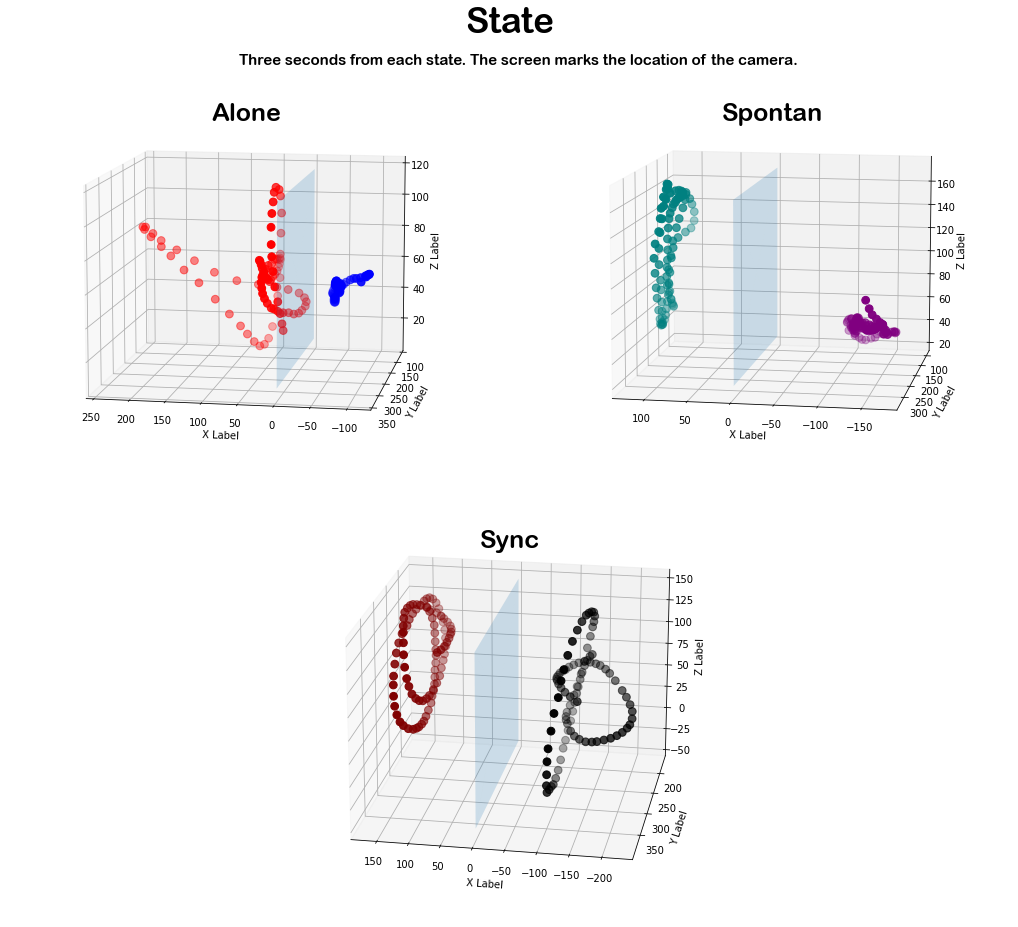

In [36]:
def Max(sr1,sr2):
    return max(max(sr1),max(sr2))
def Min(sr1,sr2):
    return min(min(sr1),min(sr2))

def scatterplot(df,c1,c2,title,elev,azim):
    ax.scatter(df['PositionXRight'], df['PositionYRight'], df['PositionZRight'], c=c1, marker='o',s=60)
    ax.scatter(df['PositionXLeft'], df['PositionYLeft'], df['PositionZLeft'], c=c2, marker='o',s=60)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ymin=Min(df['PositionYLeft'],df['PositionYRight'])
    zmin=Min(df['PositionZLeft'],df['PositionZRight'])
    ymax=Max(df['PositionYLeft'],df['PositionYRight'])
    zmax=Max(df['PositionZLeft'],df['PositionZRight'])
    x = [0, 0, 0, 0]
    y = [ymin, ymin, ymax, ymax]
    z = [zmin, zmax, zmin, zmax]
    vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
    tupleList = list(zip(x, y, z))
    poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
    collection = Poly3DCollection(poly3d, linewidths=1, alpha=0.1)
    ax.add_collection3d(collection)
    ax.set_title(title,fontsize = 25, fontweight='light',fontfamily=font, y=0.93)
    ax.view_init(elev,azim)
font='Arial Rounded MT Bold'
fig = plt.figure(3,figsize=(18,25),)
plt.text(x=0.231,y=1,s='Three seconds from each state. The screen marks the location of the camera.',fontfamily=font,fontsize = 15)
plt.title('State',fontsize = 35, fontweight='bold',fontfamily=font, y=1.03)
plt.axis('off')
ax = fig.add_subplot(221, projection='3d')
scatterplot(aa1,'r','b','Alone',10,100)
ax = fig.add_subplot(222, projection='3d')
scatterplot(aa2,'teal','purple','Spontan',10,100)
ax = fig.add_subplot(212, projection='3d')
scatterplot(aa3,'maroon','black','Sync',20,100)
plt.subplots_adjust(wspace=0.1,top=0.6,hspace=0.001)


In [85]:
def DataToVectors(df):
    first=df.iloc[:,0][0]
    last=df.iloc[:,0].iloc[-1]
    vecArr=[]
    for sec in range(first,last):
        secData=df[df.iloc[:,0]==sec].iloc[::5,:].reset_index(drop=True)
        if len(secData)>=5:
            rowArr=[]
            for index in range(0,5):
                row = secData.loc[[index]].reset_index(drop=True)
                for column in row.columns:
                    newCol = column+"_{}".format(str(index))
                    row.columns = [c.replace(column, newCol) for c in row.columns]
                rowArr.append(row)
            vector=pd.concat(rowArr,axis=1,join='inner')
            vecArr.append(vector)
    newData=pd.concat(vecArr).reset_index(drop=True)
    newData = dropCol(newData,'Time')
    newData = dropCol(newData,'ID')
    return newData

def dropCol(df,value):
    df= df[df.columns.drop(list(df.filter(regex=value)))]
    return df

In [86]:
df1=listTrain[1][0].copy()
df2=DataToVectors(df1)
# df2= df2[df2.columns.drop(list(df2.filter(regex='Time')))]


In [87]:
df2

,PositionXRight_0,PositionYRight_0,PositionZRight_0,VelocityXRight_0,VelocityYRight_0,VelocityZRight_0,PitchRight_0,RollRight_0,YawRight_0,WristPosXRight_0,...,YawLeft_4,WristPosXLeft_4,WristPosYLeft_4,WristPosZLeft_4,ElbowposXLeft_4,ElbowPosYLeft_4,ElbowPosZLeft_4,GrabStrenthLeft_4,GrabAngleLeft_4,PinchStrengthLeft_4
0,152.31350,204.6813,-39.256710,-28.56766,23.006620,8.315823,0.654996,-0.130873,-0.563396,191.4088,...,1.564091,-181.10650,268.81390,-38.074380,-340.9439,75.58416,-58.58674,0.000000,1.028968,0.000000
1,144.17730,228.7819,-40.494260,-114.62390,-84.877370,-64.320840,0.800464,-0.534337,-0.942962,196.3692,...,1.302181,-157.16730,120.97110,11.011780,-378.4770,13.29182,64.08550,0.282783,1.570952,0.000000
2,133.58210,215.4327,-42.353800,-82.87811,-117.009300,-64.883760,0.727363,-0.398594,-0.967218,188.7412,...,1.299380,-144.92770,91.49286,-4.902769,-278.0260,-97.66110,94.57204,0.000000,0.000000,0.000000
3,158.01800,185.9226,-34.486940,-29.43996,-60.690710,-1.765089,0.300492,-0.750881,-0.112199,177.4124,...,0.901522,-86.63909,176.44680,-7.657148,-217.0057,-27.33747,55.15046,0.000000,0.828752,0.000000
4,151.37700,190.4289,-37.550550,11.97787,8.386772,11.742320,0.852844,-0.747266,-0.609233,187.6167,...,1.663071,-144.10630,179.64050,13.166800,-348.2569,40.64840,-22.35272,0.371244,1.531920,0.717818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,130.23660,205.3096,7.099794,-205.28140,-298.962900,-61.276150,1.082626,-0.739234,-1.022184,176.8782,...,1.383849,-176.78090,136.05780,36.857030,-343.3712,-45.07233,29.73656,0.370299,1.340217,0.218267
63,76.84580,239.4875,10.319510,74.11671,11.654300,66.452770,0.977843,-0.570720,-0.990057,127.0536,...,1.399931,-147.93010,76.52991,34.934140,-361.7654,-19.80876,109.32110,0.000000,0.230372,0.000000
64,79.35427,195.1094,-10.123110,17.51976,-41.569360,-38.259220,0.811154,-0.469424,-0.861568,127.8289,...,1.296465,-151.82330,85.77841,36.667690,-364.3940,-33.13682,71.49445,0.000000,0.000000,0.000000
65,161.39830,275.9344,-32.807040,-16.10396,-188.312500,-4.940268,1.024441,-0.827943,-0.716253,196.9548,...,1.922205,-151.86190,126.13140,16.949200,-344.6295,-25.72706,34.82965,0.000000,0.000000,0.000000


In [65]:
vector

,TimeRight_0,FrameIDRight_0,PositionXRight_0,PositionYRight_0,PositionZRight_0,VelocityXRight_0,VelocityYRight_0,VelocityZRight_0,PitchRight_0,RollRight_0,...,YawLeft_4,WristPosXLeft_4,WristPosYLeft_4,WristPosZLeft_4,ElbowposXLeft_4,ElbowPosYLeft_4,ElbowPosZLeft_4,GrabStrenthLeft_4,GrabAngleLeft_4,PinchStrengthLeft_4
0,10,129709,158.018,185.9226,-34.48694,-29.43996,-60.69071,-1.765089,0.300492,-0.750881,...,0.901522,-86.63909,176.4468,-7.657148,-217.0057,-27.33747,55.15046,0.0,0.828752,0.0


In [61]:
vecArr=[]
for index in range(0,5):
    row = secData[secData.index==index].reset_index(drop=True)
    for column in row.columns:
        newCol = column+"_{}".format(str(index))
        row.columns = [c.replace(column, newCol) for c in row.columns]
    vecArr.append(row)
vector = pd.concat(vecArr,axis=1,join='inner')
#     if index==0:
#         vector = row
#     else:
#         vector = pd.concat([vector,row],axis=1,join='inner')

In [62]:
vector

,TimeRight_0,FrameIDRight_0,PositionXRight_0,PositionYRight_0,PositionZRight_0,VelocityXRight_0,VelocityYRight_0,VelocityZRight_0,PitchRight_0,RollRight_0,...,YawLeft_4,WristPosXLeft_4,WristPosYLeft_4,WristPosZLeft_4,ElbowposXLeft_4,ElbowPosYLeft_4,ElbowPosZLeft_4,GrabStrenthLeft_4,GrabAngleLeft_4,PinchStrengthLeft_4
0,10,129709,158.018,185.9226,-34.48694,-29.43996,-60.69071,-1.765089,0.300492,-0.750881,...,0.901522,-86.63909,176.4468,-7.657148,-217.0057,-27.33747,55.15046,0.0,0.828752,0.0


In [ ]:
df=listdata[Spontan][8]
df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]
x=df.iloc[:,0][0]
df.iloc[:,0] = df.iloc[:,0] - x
df =remove7(df)
df.hands.value_counts()
# df = df[df.hands != 1]
# df

In [ ]:
df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
df=pd.merge(df_right, df_left, left_index=True, right_index=True)
df

In [ ]:
df2 = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\Training\Evyatar Cohen\Evyatar636771053639929594Sync.csv')
ef2=pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\Training\Evyatar Cohen\Evyatar636771052727603804Spontan.csv')

# df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]


In [ ]:
df2=transform(df2,Sync)
ef2=transform(ef2,Spontan)


In [ ]:
list(ef2.columns)

In [ ]:
# for i in df.iloc[:, 1]:

df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
df2=pd.merge(df_right, df_left, left_index=True, right_index=True)
df2.columns=[c.replace('_x', 'Right').replace('_y', 'Left') for c in df2.columns]
df2

In [ ]:
f5=df3.query('72<=TimeRight<=73')
f5.stack(

In [ ]:
pd.DataFrame(f5.values.reshape(1, -1))

In [ ]:
corr = df2.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(corr, annot=True ,linewidths=0.5, ax=ax)